In [1]:
# 格子サイズの選択
lattice_size = 16

# モデルの選択 'FCN' or 'CNN'
neural_network = 'CNN'

# 隠れ層のニューロン数の選択
hidden_size = 3

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [3]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [4]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [5]:
# ファイルの相対パスを指定
file_path = f'data/Ising_data_L{lattice_size}_v3.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, label_data = loaded_data

In [6]:
# # 磁化を計算
# def magnetization(state):
#     return np.mean(state)

# for i in range(len(spin_data)):
#     mag = magnetization(spin_data[i])
#     if mag > 0:
#         spin_data[i] *= -1

In [7]:
# データのリストをNumPy配列に変換
spin_data_np = np.array(spin_data)
label_data_np = np.array(label_data)

# NumPy配列をPyTorchテンソルに変換
spin_data_tensor = torch.from_numpy(spin_data_np)
label_data_tensor = torch.from_numpy(label_data_np)

In [8]:
if neural_network == 'CNN':
    spin_data_tensor = spin_data_tensor.unsqueeze(1)
    spin_data_tensor.shape

In [9]:
# 訓練とテストに分割(5:5)
spin_train, spin_test, label_train, label_test = train_test_split(spin_data_tensor, label_data_tensor, test_size=0.5)

# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
label_train = torch.tensor(label_train, dtype=torch.float32)  
label_test = torch.tensor(label_test, dtype=torch.float32)    

C:\Users\sugay\AppData\Local\Temp\ipykernel_26472\612640267.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_26472\612640267.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_26472\612640267.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Te

In [10]:
# one-hot表現に変換する関数
def to_one_hot(data, num_classes):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    print(one_hot.size())
    # 各要素を20次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int(torch.round((val - 0.05) / 0.05))
        one_hot[i, index] = 1.0
    
    return one_hot

num_classes = 20

# one-hot表現に変換
one_hot_label_train = to_one_hot(label_train, num_classes=num_classes)
one_hot_label_test = to_one_hot(label_test, num_classes=num_classes)

torch.Size([20000, 20])


torch.Size([20000, 20])


In [11]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_label_train)
test_dataset = TensorDataset(spin_test, one_hot_label_test)

In [12]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [13]:
# DataLoaderの設定(batch_size FCN:100 CNN:500)
train_loader = DataLoader(transformed_train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=100)

モデルを定義

In [14]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=True)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.softmax(self.fc1(x), dim=1)
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
class CNN(nn.Module):
    def __init__(self,output_size):
        super(CNN, self).__init__()
        
        # 畳み込み層
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2, bias=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, bias=True)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=4, stride=4, bias=True)
        
        # 畳み込みの部分
        self.conv = nn.Sequential(
            self.conv1,   
            nn.ReLU(inplace=True),
            self.conv2,   
            nn.ReLU(inplace=True),
            self.conv3,   
            nn.ReLU(inplace=True)
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(3, output_size, bias=True),
            # nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


モデルのインスタンス化

In [15]:
input_size = 16*16
hidden_size = hidden_size
output_size = 20

if neural_network == 'FCN':
    model = FCN(input_size, hidden_size, output_size)
elif neural_network == 'CNN':
    model = CNN(output_size)

model.to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(4, 4), stride=(4, 4))
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(4, 4), stride=(4, 4))
    (5): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
  )
)


損失関数と最適化アルゴリズムの設定

In [16]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.003)     # lr FCN:0.002 CNN:0.004


学習の実行

In [17]:
num_epochs = 20 # FCN:1000 CNN:100
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      
        targets = torch.argmax(targets, dim=1) 
        running_acc += torch.mean(pred.eq(targets).float().cpu()) 
        optimizer.step()
    running_loss /= len(train_loader)   
    running_acc /= len(train_loader)    
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      
        test_targets = torch.argmax(test_targets, dim=1)  
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) 
    test_running_loss /= len(test_loader)   
    test_running_acc /= len(test_loader)    
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {:.3f}, acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 2.584, acc: 0.108, test loss: 2.176, test acc: 0.145
epoch: 1, loss: 1.927, acc: 0.224, test loss: 1.722, test acc: 0.287
epoch: 2, loss: 1.690, acc: 0.298, test loss: 1.657, test acc: 0.317
epoch: 3, loss: 1.645, acc: 0.316, test loss: 1.621, test acc: 0.329
epoch: 4, loss: 1.636, acc: 0.319, test loss: 1.659, test acc: 0.325
epoch: 5, loss: 1.610, acc: 0.330, test loss: 1.600, test acc: 0.332
epoch: 6, loss: 1.602, acc: 0.331, test loss: 1.605, test acc: 0.326
epoch: 7, loss: 1.599, acc: 0.333, test loss: 1.622, test acc: 0.323
epoch: 8, loss: 1.592, acc: 0.339, test loss: 1.603, test acc: 0.331
epoch: 9, loss: 1.595, acc: 0.335, test loss: 1.578, test acc: 0.344
epoch: 10, loss: 1.582, acc: 0.342, test loss: 1.616, test acc: 0.336
epoch: 11, loss: 1.592, acc: 0.337, test loss: 1.586, test acc: 0.334
epoch: 12, loss: 1.583, acc: 0.338, test loss: 1.602, test acc: 0.328
epoch: 13, loss: 1.578, acc: 0.340, test loss: 1.608, test acc: 0.329
epoch: 14, loss: 1.578, acc: 0

図をプロット

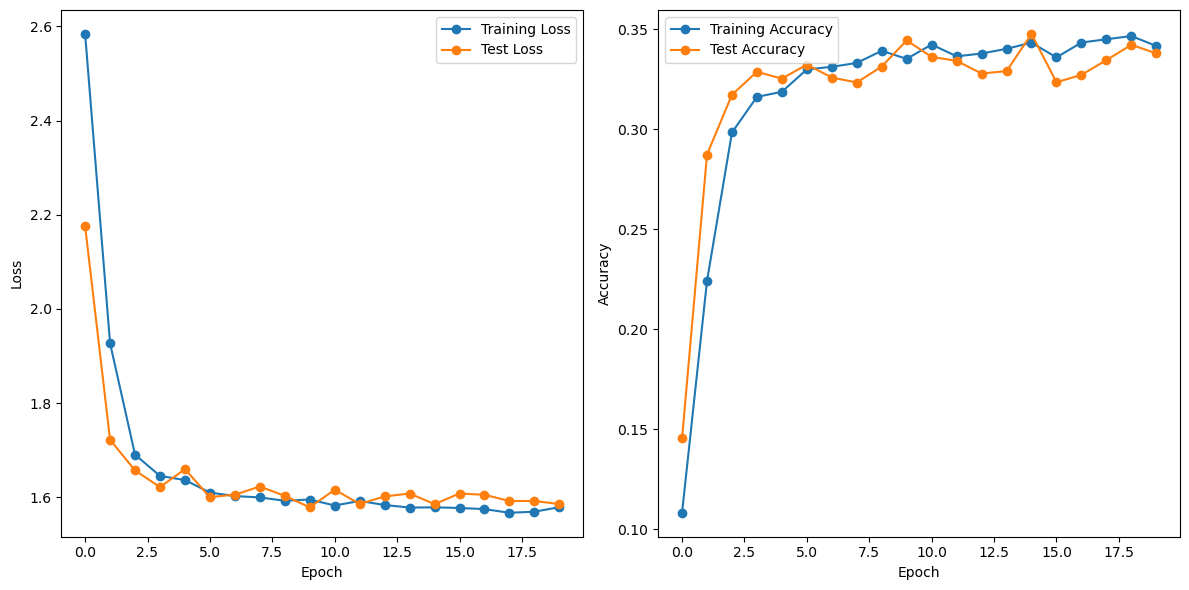

In [18]:
# グラフの作成
plt.figure(figsize=(12, 6))

# トレーニングおよびバリデーションの損失をプロット
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
# plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# トレーニングおよびバリデーションの精度をプロット
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', marker='o')
plt.plot(test_accs, label='Test Accuracy', marker='o')
# plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# グラフの表示
plt.tight_layout()
# グラフを保存
plt.savefig(f'image/L{lattice_size}_{neural_network}_Nh{hidden_size}_graph.png')  # ファイル名を適切に指定
plt.show()


モデルの保存

In [19]:
class_name = type(model).__name__


file_path = f'data/prm_data_L{lattice_size}_{class_name}_Nh{hidden_size}.pth'
print(file_path)
torch.save(model.state_dict(), file_path)

data/prm_data_L16_CNN_Nh3.pth
